In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import load_model as tfk__load_model


2023-06-12 15:12:24.416718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 15:12:30.601327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## cleaner function

In [21]:

# fitted_model = tfk__load_model('absenteeism_model.h5')    
def load_and_clean_data(data_csv, scaler_file):

    # import the data
    df = pd.read_csv(data_csv)
    # store the data within the object for later use
    df_with_predicitons = df.copy()
    # drop the ID column
    df = df.drop(['ID'], axis=1)
    # to preserve the same structure of our previous code, we will add the target column here but with NaN
    df['Absenteeism Time in Hours'] = 'NaN'

    # create a seperate dataframe for dummy variables
    reason_columns = pd.get_dummies(df['Reason for Absence'], drop_first=True)

    # split reason_columns into 4 types
    reason_type_1 = reason_columns.loc[:, 1:14].max(axis=1)
    reason_type_2 = reason_columns.loc[:, 15:17].max(axis=1)
    reason_type_3 = reason_columns.loc[:, 18:21].max(axis=1)
    reason_type_4 = reason_columns.loc[:, 22:].max(axis=1)

    # to avoid multicollinearity, drop the 'Reason for Absence' column from df
    df.drop(['Reason for Absence'], axis=1, inplace=True)

    # concatenate df and the 4 types of reason for absence
    df = pd.concat([df, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis=1)

    # assign names to the 4 reason type columns
    # df.columns = ['Transportation Expense', 'Distance to Work', 'Age',
    #       'Daily Work Load Average', 'Body Mass Index', 'Education',
    #       'Children', 'Pets', 'Absenteeism Time in Hours', 'Month Value', 'Day of the Week', 
    #       'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4',]
    df.rename(columns={0: 'Reason_1', 1: 'Reason_2', 2: 'Reason_3', 3: 'Reason_4'}, inplace=True)
    # print(df.head())
    # convert the 'Date' column into datetime
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, format="%d/%m/%Y")

    # extract month and day of the week value from column Date
    df['Month Value'] = df['Date'].dt.month
    df['Day of the Week'] = df['Date'].dt.day_of_week
    df.drop('Date', axis=1, inplace=True)

        # reorder the columns
    df = df[['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month Value',
            'Day of the Week', 'Transportation Expense', 'Distance to Work',
            'Age', 'Daily Work Load Average', 'Body Mass Index', 'Education',
            'Children', 'Pets', 'Absenteeism Time in Hours']]
    
    # Education to dummies
    df['Education'] = df['Education'].map({1:0, 2:1, 3:1, 4:1})

    # replace the NaN values
    df = df.fillna(value=0)

    # drop the original absenteeism time
    df = df.drop(['Absenteeism Time in Hours'],axis=1)
    
    # drop the variables we decide we don't need
    # I inlcuded 'Education' because in my version, 'Education' is also a useless parameter
    # df = df.drop(['Day of the Week','Daily Work Load Average','Distance to Work', 'Education'],axis=1)
    
    # we have included this line of code if you want to call the 'preprocessed data'
    preprocessed_data = df.copy()

    dummy_cols = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']

    # exclude the dummies from scaler function
    tobe_scaled_cols = df.loc[:, ~df.columns.isin(dummy_cols)].columns.values
    
    with open(scaler_file, 'rb') as sc:
        scaler = pickle.load(sc)
    scaled_inputs = scaler.transform(df[tobe_scaled_cols])

    # concatenate the dummies
    scaled_inputs_df = pd.DataFrame(data=scaled_inputs, columns=tobe_scaled_cols)
    data = pd.concat([df[dummy_cols], scaled_inputs_df], axis=1) 
    return data, preprocessed_data



In [22]:
new_data, unscaled_data = load_and_clean_data('Absenteeism_new_data.csv', 'absenteeism_scaler')

In [23]:
tfmodel = tfk__load_model('absenteeism_model.h5')
# fitted_model.evaluate('../')

In [24]:
new_data.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets
0,False,0.0,False,True,-0.102784,1.344231,-0.654143,-0.263140,-1.006686,-0.853789,-1.819793,2.232242,-0.919030,-0.589690
1,True,0.0,False,False,-0.102784,-1.359682,2.092381,1.494345,-1.320435,-0.853789,0.061825,-0.447980,-0.019280,2.843016
2,False,0.0,False,True,-0.102784,-0.007725,-1.016322,-1.209478,-0.379188,-0.853789,-0.408580,-0.447980,0.880469,-0.589690
3,False,0.0,False,True,-0.102784,1.344231,-0.654143,-0.533522,0.562059,-0.853789,-1.114186,2.232242,0.880469,-0.589690
4,True,0.0,False,False,-0.102784,1.344231,-1.016322,-1.209478,-0.379188,-0.853789,-0.408580,-0.447980,0.880469,-0.589690


In [25]:
x = np.asarray(new_data).astype('float32')

In [26]:
tensorData = tf.convert_to_tensor(x)

In [27]:
predicted_result = tfmodel.predict(x)

2/2 [==============================] - 0s 2ms/step


In [28]:
predicted_result

array([[0.13952322],
       [0.8704048 ],
       [0.29811144],
       [0.19340254],
       [0.5732989 ],
       [0.72202265],
       [0.45661134],
       [0.1786873 ],
       [0.1052721 ],
       [0.41322753],
       [0.46206832],
       [0.4571003 ],
       [0.22681977],
       [0.13656506],
       [0.13180661],
       [0.25728056],
       [0.4571003 ],
       [0.44665125],
       [0.38033733],
       [0.5693227 ],
       [0.18433529],
       [0.05385768],
       [0.34198353],
       [0.4168747 ],
       [0.06258371],
       [0.4695955 ],
       [0.2306987 ],
       [0.59777343],
       [0.18538465],
       [0.5589177 ],
       [0.30202526],
       [0.1419565 ],
       [0.52805406],
       [0.30202118],
       [0.967336  ],
       [0.8896069 ],
       [0.7054479 ],
       [0.02548965],
       [0.32993215],
       [0.07756863]], dtype=float32)

In [29]:
unscaled_data['Probability'] = predicted_result

In [30]:
unscaled_data

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Probability
0,False,0.0,False,True,6,4,179,26,30,237.656,19,1,0,0,0.139523
1,True,0.0,False,False,6,0,361,52,28,237.656,27,0,1,4,0.870405
2,False,0.0,False,True,6,2,155,12,34,237.656,25,0,2,0,0.298111
3,False,0.0,False,True,6,4,179,22,40,237.656,22,1,2,0,0.193403
4,True,0.0,False,False,6,4,155,12,34,237.656,25,0,2,0,0.573299
5,True,0.0,False,False,6,0,225,26,28,237.656,24,0,1,2,0.722023
6,True,0.0,False,False,6,2,118,15,46,275.089,25,0,2,0,0.456611
7,False,0.0,False,True,6,2,179,26,30,275.089,19,1,0,0,0.178687
8,False,0.0,False,True,6,4,118,10,37,275.089,28,0,0,0,0.105272
9,True,0.0,False,False,6,2,118,10,37,275.089,28,0,0,0,0.413228


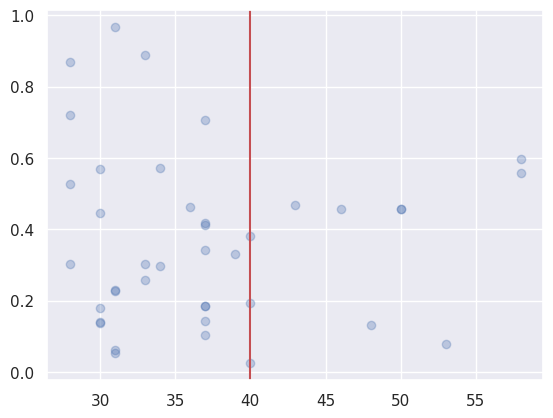

In [35]:
plt.scatter(unscaled_data['Age'], unscaled_data['Probability'], alpha=0.3)
plt.axvline(x=40, color='r')

In [36]:
avg_prob = unscaled_data.groupby(['Age'])['Probability'].mean().reset_index()
avg_prob

,Age,Probability
0,28,0.605626
1,30,0.294150
2,31,0.308259
3,33,0.482971
4,34,0.435705
5,36,0.462068
6,37,0.311810
7,39,0.329932
8,40,0.199743
9,43,0.469595


Text(0, 0.5, 'Average Probability')

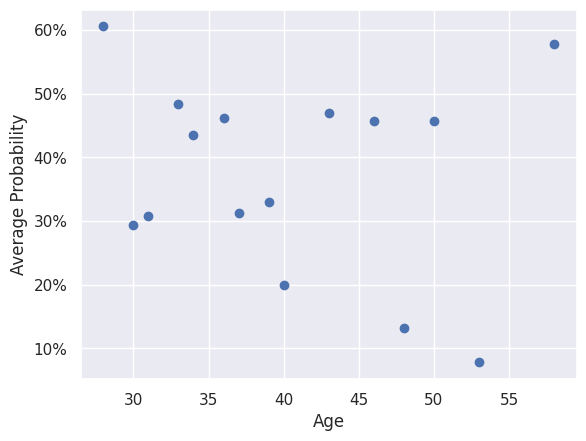

In [56]:
import matplotlib.ticker as mtick
plot = plt.scatter(avg_prob['Age'], avg_prob['Probability'])
# yticks = mtick.PercentFormatter(100.0)
yticks = mtick.PercentFormatter(1.0)
# plot.axes.yaxis.set_major_formatter(mtick.PercentFormatter())
plot.axes.yaxis.set_major_formatter(yticks)
plot.axes.set_xlabel('Age')
plot.axes.set_ylabel('Average Probability')

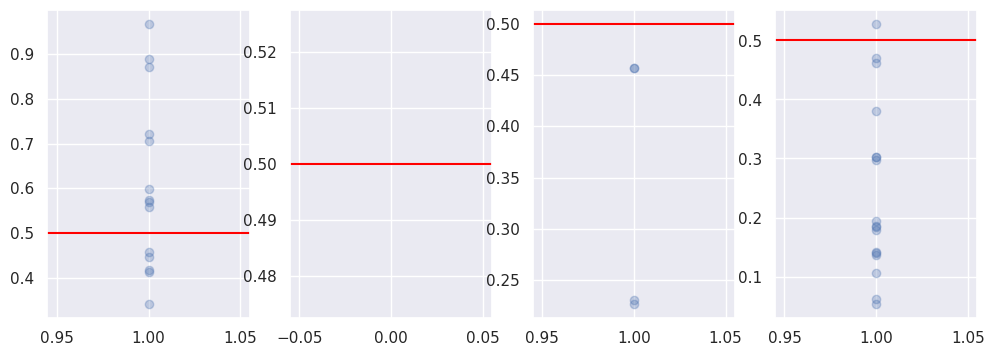

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
axs[0].scatter(unscaled_data.loc[unscaled_data['Reason_1']==1, 'Reason_1'], unscaled_data.loc[unscaled_data['Reason_1']==1, 'Probability'], alpha=0.3)
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[1].scatter(unscaled_data.loc[unscaled_data['Reason_2']==1, 'Reason_2'], unscaled_data.loc[unscaled_data['Reason_2']==1, 'Probability'], alpha=0.3)
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[2].scatter(unscaled_data.loc[unscaled_data['Reason_3']==1, 'Reason_3'], unscaled_data.loc[unscaled_data['Reason_3']==1, 'Probability'], alpha=0.3)
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[3].scatter(unscaled_data.loc[unscaled_data['Reason_4']==1, 'Reason_4'], unscaled_data.loc[unscaled_data['Reason_4']==1, 'Probability'], alpha=0.3)
axs[3].axhline(y=0.5, color='red', linestyle='-')

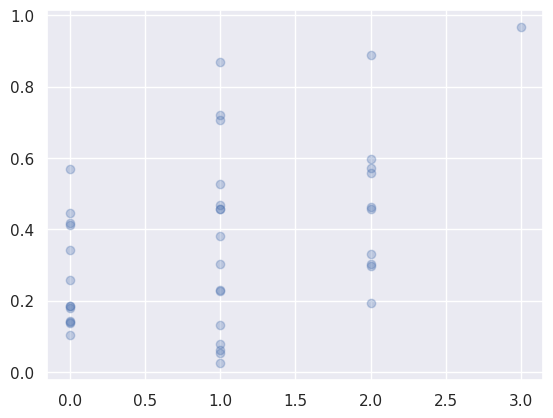

In [58]:
plt.scatter(unscaled_data['Children'], unscaled_data['Probability'], alpha=0.3)

In [60]:
child_avg_prob = unscaled_data.groupby(['Children'])['Probability'].mean().reset_index()
child_avg_prob

,Children,Probability
0,0,0.270543
1,1,0.356307
2,2,0.466175
3,3,0.967336
